<a href="https://colab.research.google.com/github/Ashish-Abraham/LLM-Boilerplate/blob/main/LLMLogitsBlog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import List, Tuple, Dict
import numpy as np



class LLMLayerAnalyzer:
    def __init__(self, model_name: str = "deepseek-ai/deepseek-coder-1.3b-base"):
        """
        Initialize the LLM analyzer with a specified model.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            output_hidden_states=True,
            return_dict=True
        ).to(self.device)

        # Register hooks for all transformer layers
        self.activation = {}
        self.hooks = []
        self._register_hooks()

    def _get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output
        return hook

    def _register_hooks(self):
        """Register forward hooks for all transformer layers"""
        for name, layer in self.model.named_modules():
            if "layer" in name and isinstance(layer, torch.nn.Module):
                hook = layer.register_forward_hook(self._get_activation(name))
                self.hooks.append(hook)

    def analyze_text(self, text: str) -> Tuple[List[str], Dict[str, torch.Tensor]]:
        """
        Analyze text through the model and return token and layer information.
        """
        # Tokenize input
        inputs = self.tokenizer(text, return_tensors="pt").to(self.device)

        # Forward pass through model
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Get tokens for each position
        tokens = self.tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

        return tokens, self.activation

    def generate_next_token(self, text: str, top_k: int = 5) -> Tuple[str, List[Tuple[str, float]], Dict[str, torch.Tensor]]:
        """
        Generate the next token and return top predictions with their probabilities.

        Args:
            text: Input text
            top_k: Number of top predictions to return

        Returns:
            Tuple of (selected token, list of (token, probability) pairs, layer activations)
        """
        inputs = self.tokenizer(text, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            next_token_logits = outputs.logits[0, -1, :]

            # Apply softmax to get probabilities
            next_token_probs = torch.nn.functional.softmax(next_token_logits, dim=0)

            # Get top k predictions
            top_k_probs, top_k_indices = torch.topk(next_token_probs, top_k)

            # Convert to tokens and probabilities
            top_predictions = []
            for prob, idx in zip(top_k_probs, top_k_indices):
                token = self.tokenizer.decode([idx])
                top_predictions.append((token, prob.item()))

            # Select the top token
            next_token = top_predictions[0][0]

        return next_token, top_predictions, self.activation

    def visualize_layer_output(self, layer_name: str, activation: torch.Tensor, token_positions: List[str] = None):
        """
        Visualize the output of a specific layer.
        """
        # Convert to numpy for visualization
        activation_np = activation.detach().cpu().numpy()

        print(f"\nLayer: {layer_name}")
        print(f"Shape: {activation_np.shape}")

        # If this is the final layer output, show per-token statistics
        if token_positions and activation_np.shape[1] == len(token_positions):
            print("\nPer-token statistics:")
            for i, token in enumerate(token_positions):
                token_activations = activation_np[0, i, :]
                print(f"\nToken: '{token}'")
                print(f"Mean activation: {np.mean(token_activations):.4f}")
                print(f"Std deviation: {np.std(token_activations):.4f}")
                print(f"Max activation: {np.max(token_activations):.4f}")
                print(f"Min activation: {np.min(token_activations):.4f}")
        else:
            # General statistics
            print(f"Mean activation: {np.mean(activation_np):.4f}")
            print(f"Std deviation: {np.std(activation_np):.4f}")
            print(f"Max activation: {np.max(activation_np):.4f}")
            print(f"Min activation: {np.min(activation_np):.4f}")

    def cleanup(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()

def main():
    # Initialize analyzer
    analyzer = LLMLayerAnalyzer()

    # Analyze a sample text
    text = "def fibonacci(n):"
    print(f"\nAnalyzing text: '{text}'")

    # Get tokens and layer activations
    tokens, activations = analyzer.analyze_text(text)

    # Print tokens
    print("\nInput tokens:")
    for i, token in enumerate(tokens):
        print(f"Position {i}: {token}")

    # Visualize layer outputs with token information
    for layer_name, activation in activations.items():
        if isinstance(activation, torch.Tensor):
            analyzer.visualize_layer_output(layer_name, activation, tokens)

    # Generate and show top predictions for next token
    next_token, top_predictions, next_activations = analyzer.generate_next_token(text)

    print("\nTop predicted next tokens:")
    for token, prob in top_predictions:
        print(f"Token: '{token}' - Probability: {prob:.4f}")

    print(f"\nSelected next token: '{next_token}'")

    # Clean up
    analyzer.cleanup()

if __name__ == "__main__":
    main()

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import List, Tuple, Dict, Set
import numpy as np




class LLMLayerAnalyzer:
    def __init__(self, model_name: str = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            output_hidden_states=True,
            return_dict=True
        ).to(self.device)

        # Get reference to the LM head (output layer)
        self.lm_head = None
        for name, module in self.model.named_modules():
            if 'lm_head' in name or isinstance(module, torch.nn.Linear) and module.out_features == self.model.config.vocab_size:
                self.lm_head = module
                self.lm_head_name = name
                print(f"Found LM head: {name}")
                break

        if self.lm_head is None:
            print("Warning: Could not find LM head. Using a generic projection for demonstration.")
            # In this case, we'd need to create a simple projection layer

        self.target_layers = self._get_target_layer_names()
        self.activation = {}
        self.hooks = []

        self._register_hooks()

    def _get_target_layer_names(self) -> Set[str]:
        """Get names of key layers to monitor."""
        all_layers = [name for name, _ in self.model.named_modules() if "layer" in name]
        num_layers = len([l for l in all_layers if l.count('.') == 1])  # Number of transformer layers

        # Select more layers by choosing finer granularity
        target_indices = [0, max(1, num_layers // 6), num_layers // 4, num_layers // 2, num_layers - 2, num_layers - 1]

        target_layers = set()
        for i in target_indices:
            base_name = f"model.layers.{i}"
            target_layers.add(base_name)
            target_layers.add(f"{base_name}.self_attn")
            target_layers.add(f"{base_name}.mlp")

        target_layers.add("model.norm")  # Ensure final normalization layer is captured
        return target_layers


    def _get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output
        return hook

    def _register_hooks(self):
        registered = []
        for name, layer in self.model.named_modules():
            if any(name.startswith(target) for target in self.target_layers):
                hook = layer.register_forward_hook(self._get_activation(name))
                self.hooks.append(hook)
                registered.append(name)

        print(f"Registered hooks for layers: {registered}")


    def predict_token_from_hidden(self, hidden_state):
        """Predict token from a hidden state by applying the LM head"""
        if self.lm_head is not None:
            # Apply layer norm if needed (depends on model architecture)
            if hasattr(self.model, 'norm') and 'norm' in self.activation:
                # Some models apply norm before lm_head
                normalized = self.activation['model.norm']
                if isinstance(normalized, tuple):
                    normalized = normalized[0]
                hidden_normed = normalized[:, -1:, :]
            else:
                # If we can't find the right norm layer, just use as is
                hidden_normed = hidden_state[:, -1:, :]

            # Apply LM head to get logits
            logits = self.lm_head(hidden_normed)
            return logits.squeeze(1)
        else:
            # Fallback: Create a simple projection (this is just for demonstration)
            # In a real scenario, we'd need to extract the actual LM head weights
            projection = torch.nn.Linear(hidden_state.shape[-1], self.model.config.vocab_size).to(self.device)
            logits = projection(hidden_state[:, -1:, :])
            return logits.squeeze(1)

    def analyze_token_generation(self, text: str, top_k: int = 5) -> Dict:
        """
        Analyze token generation process with predictions at each layer
        """
        inputs = self.tokenizer(text, return_tensors="pt").to(self.device)

        with torch.no_grad():
            # Get full model output
            outputs = self.model(**inputs)
            final_logits = outputs.logits[0, -1, :]
            hidden_states = outputs.hidden_states

            # Get probabilities and top predictions
            final_probs = torch.nn.functional.softmax(final_logits, dim=0)
            top_k_probs, top_k_indices = torch.topk(final_probs, top_k)

            # Analyze progression through layers
            layer_analysis = {}
            layer_predictions = {}

            # For each monitored layer
            for layer_name, activation in self.activation.items():
                if isinstance(activation, torch.Tensor):
                    # Skip attention layers for token prediction (they don't have the right shape)
                    if "self_attn" in layer_name and activation.dim() != 3:
                        continue

                    # Get layer output vector
                    if activation.dim() == 3:  # Only use 3D tensors (batch, seq_len, hidden_dim)
                        layer_vector = activation[0, -1, :].detach().cpu().numpy()

                        # For main layers, try to predict the token at this layer
                        if not any(x in layer_name for x in ["self_attn.", "mlp."]):
                            try:
                                # Get logits by applying the LM head to this layer's hidden state
                                layer_logits = self.predict_token_from_hidden(activation)
                                layer_probs = torch.nn.functional.softmax(layer_logits, dim=-1)
                                top_layer_probs, top_layer_indices = torch.topk(layer_probs[0], top_k)

                                # Get top predictions at this layer
                                layer_predictions[layer_name] = []
                                for prob, idx in zip(top_layer_probs, top_layer_indices):
                                    token = self.tokenizer.decode([idx])
                                    token_id = idx.item()
                                    layer_predictions[layer_name].append({
                                        'token': token,
                                        'id': token_id,
                                        'probability': float(prob)
                                    })
                            except Exception as e:
                                print(f"Error predicting token at layer {layer_name}: {e}")

                        layer_analysis[layer_name] = {
                            'vector': layer_vector,
                            'mean': float(np.mean(layer_vector)),
                            'std': float(np.std(layer_vector)),
                            'max': float(np.max(layer_vector)),
                            'min': float(np.min(layer_vector)),
                            'shape': layer_vector.shape
                        }

            # Final output analysis
            final_vector = final_logits.detach().cpu().numpy()
            top_tokens = []

            # Get top token predictions with probabilities
            for prob, idx in zip(top_k_probs, top_k_indices):
                token = self.tokenizer.decode([idx])
                token_id = idx.item()
                top_tokens.append({
                    'token': token,
                    'id': token_id,
                    'logit': float(final_logits[idx]),
                    'probability': float(prob)
                })

            analysis_results = {
                'layer_analysis': layer_analysis,
                'layer_predictions': layer_predictions,
                'final_vector': final_vector,
                'top_tokens': top_tokens,
                'final_vector_stats': {
                    'mean': float(np.mean(final_vector)),
                    'std': float(np.std(final_vector)),
                    'max': float(np.max(final_vector)),
                    'min': float(np.min(final_vector))
                }
            }

            return analysis_results

    def print_analysis(self, text: str, analysis_results: Dict):
        """Print detailed analysis results with token predictions at each layer"""
        print(f"\nAnalyzing text: '{text}'\n")

        # Print layer progression with token predictions
        print("=== Layer Progression and Token Predictions ===")

        # Order layers by their position in the model
        layer_names = sorted(analysis_results['layer_predictions'].keys(),
                            key=lambda x: int(x.split('.')[-1]) if '.' in x and x.split('.')[-1].isdigit() else 999)

        for layer_name in layer_names:
            if layer_name in analysis_results['layer_analysis']:
                layer_data = analysis_results['layer_analysis'][layer_name]
                print(f"\n{'-'*50}")
                print(f"Layer: {layer_name}")
                print(f"Shape: {layer_data['shape']}")
                print(f"Vector excerpt: {layer_data['vector'][:5]}")
                print(f"Max: {layer_data['max']:.4f}, Min: {layer_data['min']:.4f}")

                # Print token predictions at this layer
                if layer_name in analysis_results['layer_predictions']:
                    print("\nToken predictions at this layer:")
                    for i, pred in enumerate(analysis_results['layer_predictions'][layer_name][:3]):
                        print(f"  {i+1}. '{pred['token']}' (ID: {pred['id']}) - Prob: {pred['probability']:.4f}")

        # Print final token predictions
        print(f"\n{'-'*50}")
        print("\n=== Final Output Predictions ===")
        print("Top tokens:")
        for i, token_data in enumerate(analysis_results['top_tokens'][:5]):
            print(f"  {i+1}. '{token_data['token']}' (ID: {token_data['id']}) - Prob: {token_data['probability']:.4f}")

    def cleanup(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()

def main():
    # Initialize analyzer
    torch.cuda.empty_cache()

    analyzer = LLMLayerAnalyzer()

    # Test text
    text = "Hold my"

    # Get analysis results
    analysis_results = analyzer.analyze_token_generation(text)

    # Print detailed analysis
    analyzer.print_analysis(text, analysis_results)

    # Clean up
    analyzer.cleanup()

if __name__ == "__main__":
    main()




Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Found LM head: lm_head
Registered hooks for layers: ['model.layers.0', 'model.layers.0.self_attn', 'model.layers.0.self_attn.q_proj', 'model.layers.0.self_attn.k_proj', 'model.layers.0.self_attn.v_proj', 'model.layers.0.self_attn.o_proj', 'model.layers.0.mlp', 'model.layers.0.mlp.gate_proj', 'model.layers.0.mlp.up_proj', 'model.layers.0.mlp.down_proj', 'model.layers.0.mlp.act_fn', 'model.layers.0.input_layernorm', 'model.layers.0.post_attention_layernorm', 'model.layers.1', 'model.layers.1.self_attn', 'model.layers.1.self_attn.q_proj', 'model.layers.1.self_attn.k_proj', 'model.layers.1.self_attn.v_proj', 'model.layers.1.self_attn.o_proj', 'model.layers.1.mlp', 'model.layers.1.mlp.gate_proj', 'model.layers.1.mlp.up_proj', 'model.layers.1.mlp.down_proj', 'model.layers.1.mlp.act_fn', 'model.layers.1.input_layernorm', 'model.layers.1.post_attention_layernorm', 'model.layers.10', 'model.layers.10.self_attn', 'model.layers.10.self_attn.q_proj', 'model.layers.10.self_attn.k_proj', 'model.laye

Using device: cuda
Found LM head: lm_head
Registered hooks for layers: ['model.layers.0', 'model.layers.0.self_attn', 'model.layers.0.self_attn.q_proj', 'model.layers.0.self_attn.k_proj', 'model.layers.0.self_attn.v_proj', 'model.layers.0.self_attn.o_proj', 'model.layers.0.mlp', 'model.layers.0.mlp.gate_proj', 'model.layers.0.mlp.up_proj', 'model.layers.0.mlp.down_proj', 'model.layers.0.mlp.act_fn', 'model.layers.0.input_layernorm', 'model.layers.0.post_attention_layernorm', 'model.layers.1', 'model.layers.1.self_attn', 'model.layers.1.self_attn.q_proj', 'model.layers.1.self_attn.k_proj', 'model.layers.1.self_attn.v_proj', 'model.layers.1.self_attn.o_proj', 'model.layers.1.mlp', 'model.layers.1.mlp.gate_proj', 'model.layers.1.mlp.up_proj', 'model.layers.1.mlp.down_proj', 'model.layers.1.mlp.act_fn', 'model.layers.1.input_layernorm', 'model.layers.1.post_attention_layernorm', 'model.layers.10', 'model.layers.10.self_attn', 'model.layers.10.self_attn.q_proj', 'model.layers.10.self_attn.k

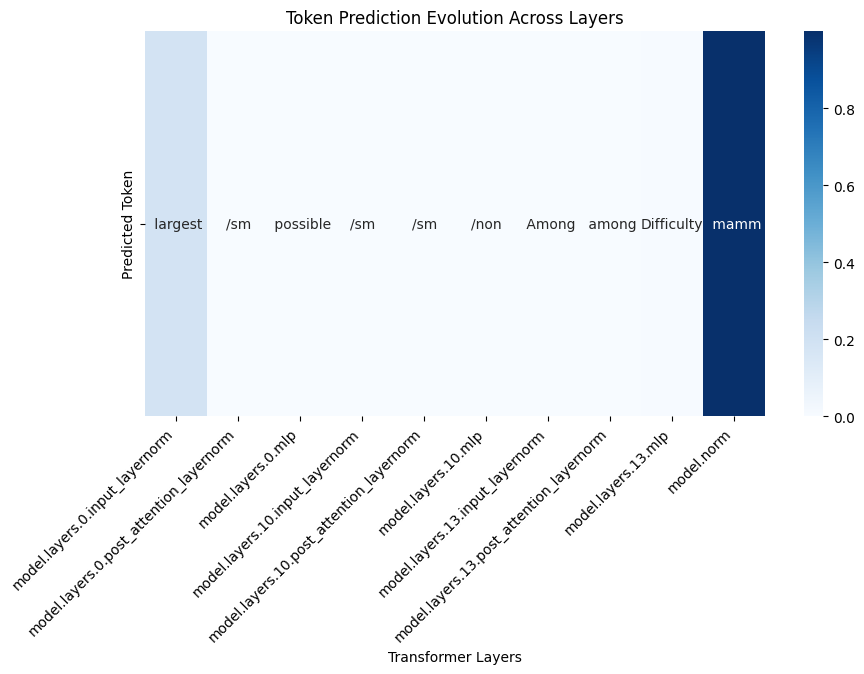

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_layer_predictions(analysis_results):
    """
    Visualizes the evolution of token predictions across selected layers.
    """
    # Select only key layers instead of all layers
    layer_names = sorted(
        analysis_results['layer_predictions'].keys(),
        key=lambda x: int(x.split('.')[-1]) if '.' in x and x.split('.')[-1].isdigit() else 999
    )

    # Reduce the number of layers shown
    print(len(layer_names))
    if len(layer_names) > 6:
        key_layers = [layer_names[0], layer_names[1], layer_names[2], layer_names[6], layer_names[7],
                      layer_names[8], layer_names[15], layer_names[16], layer_names[17],  layer_names[-1]]
    else:
        key_layers = layer_names  # If few layers exist, show all

    tokens = []
    probabilities = []

    for layer_name in key_layers:
        layer_preds = analysis_results['layer_predictions'].get(layer_name, [])
        if layer_preds:
            tokens.append(layer_preds[0]['token'])  # Take the top predicted token
            probabilities.append(layer_preds[0]['probability'])
        else:
            tokens.append("[Unknown]")
            probabilities.append(0.0)

    # Normalize probabilities for better visualization
    probabilities = np.array(probabilities)
    if probabilities.max() > probabilities.min():
        probabilities = (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min() + 1e-5)

    plt.figure(figsize=(10, 5))
    sns.heatmap([probabilities], cmap="Blues", annot=[[t for t in tokens]], fmt="",
                xticklabels=key_layers, yticklabels=["Predicted Token"], cbar=True)

    plt.xticks(rotation=45, ha='right')
    plt.title("Token Prediction Evolution Across Layers")
    plt.xlabel("Transformer Layers")
    plt.show()

# Example usage after running analysis
if __name__ == "__main__":
    analyzer = LLMLayerAnalyzer()
    text = "African elephant is the largest"
    analysis_results = analyzer.analyze_token_generation(text)
    visualize_layer_predictions(analysis_results)
    analyzer.cleanup()


Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Found LM head: lm_head
Registered hooks for layers: ['model.layers.0', 'model.layers.0.self_attn', 'model.layers.0.self_attn.q_proj', 'model.layers.0.self_attn.k_proj', 'model.layers.0.self_attn.v_proj', 'model.layers.0.self_attn.o_proj', 'model.layers.0.mlp', 'model.layers.0.mlp.gate_proj', 'model.layers.0.mlp.up_proj', 'model.layers.0.mlp.down_proj', 'model.layers.0.mlp.act_fn', 'model.layers.0.input_layernorm', 'model.layers.0.post_attention_layernorm', 'model.layers.1', 'model.layers.1.self_attn', 'model.layers.1.self_attn.q_proj', 'model.layers.1.self_attn.k_proj', 'model.layers.1.self_attn.v_proj', 'model.layers.1.self_attn.o_proj', 'model.layers.1.mlp', 'model.layers.1.mlp.gate_proj', 'model.layers.1.mlp.up_proj', 'model.layers.1.mlp.down_proj', 'model.layers.1.mlp.act_fn', 'model.layers.1.input_layernorm', 'model.layers.1.post_attention_layernorm', 'model.layers.10', 'model.layers.10.self_attn', 'model.layers.10.self_attn.q_proj', 'model.layers.10.self_attn.k_proj', 'model.laye

<ipython-input-5-4629d533a143>:88: UserWarning: Glyph 22909 (\N{CJK UNIFIED IDEOGRAPH-597D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-5-4629d533a143>:88: UserWarning: Glyph 21527 (\N{CJK UNIFIED IDEOGRAPH-5417}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-5-4629d533a143>:88: UserWarning: Glyph 34588 (\N{CJK UNIFIED IDEOGRAPH-871C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-5-4629d533a143>:88: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-5-4629d533a143>:88: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22909 (\N{CJK UNIFIED IDEOGRAPH-597D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/p

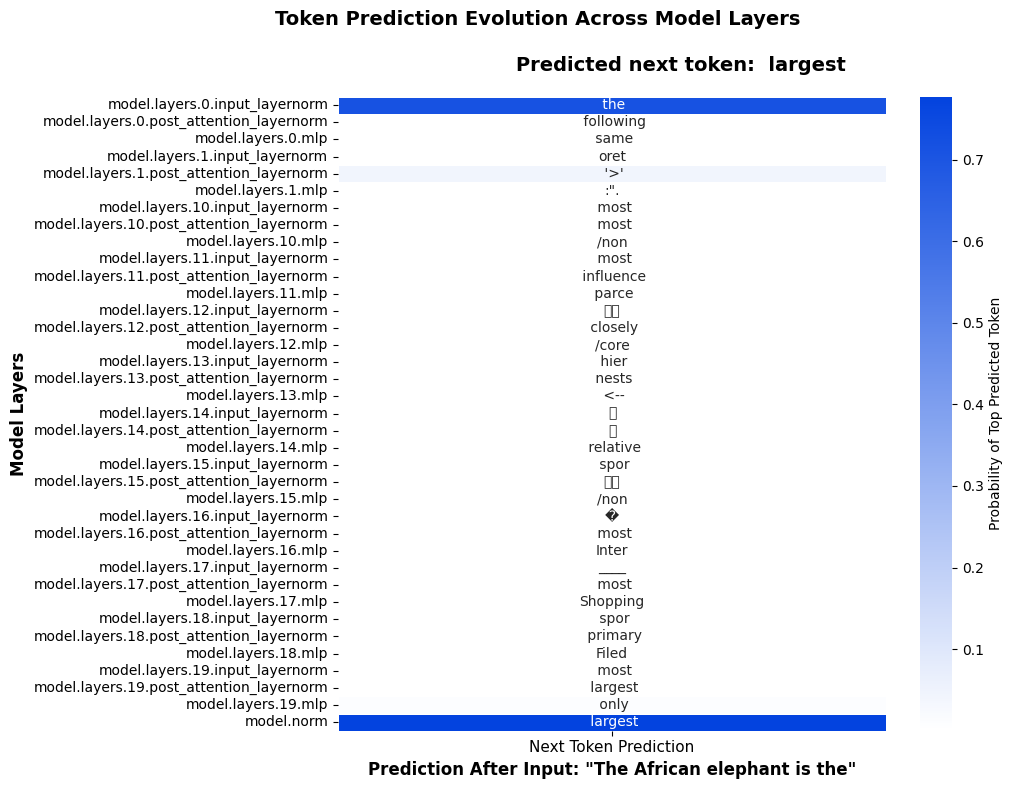

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from typing import Dict, Optional

def visualize_token_predictions_by_layer(
    input_text: str,
    analysis_results: Dict,
    ground_truth: Optional[str] = None
):
    """
    Visualizes token predictions across model layers for a single next token,
    using real outputs from the LLMLayerAnalyzer.

    Args:
        input_text: The input text as a string
        analysis_results: Results from LLMLayerAnalyzer.analyze_token_generation
        ground_truth: Optional expected continuation (if available)
    """
    # Extract the top predicted token from each layer
    layer_names = sorted(
        analysis_results['layer_predictions'].keys(),
        key=lambda x: int(x.split('.')[-1]) if '.' in x and x.split('.')[-1].isdigit() else 999
    )

    # Get the top output token (final prediction)
    final_output_token = analysis_results['top_tokens'][0]['token'] if analysis_results['top_tokens'] else "[UNKNOWN]"

    # Setup figure with GridSpec
    fig = plt.figure(figsize=(10, 8))  # Reduced width for a cleaner look
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])

    # Create a custom colormap from white to deep blue
    cmap = LinearSegmentedColormap.from_list('WhiteToBlue', ['#FFFFFF', '#0343DF'])

    # Top subplot for output token
    ax_top = plt.subplot(gs[0])
    ax_top.axis('off')
    ax_top.text(0.5, 0.5, f"Predicted next token: {final_output_token}",
                ha='center', va='center', fontsize=14, fontweight='bold')

    # Setup data for the heatmap
    num_layers = len(layer_names)

    # Extract top tokens and probabilities for each layer
    tokens, probabilities = [], []

    for layer_name in layer_names:
        layer_preds = analysis_results['layer_predictions'].get(layer_name, [])
        if layer_preds:
            tokens.append(layer_preds[0]['token'])
            probabilities.append(layer_preds[0]['probability'])
        else:
            tokens.append("[N/A]")
            probabilities.append(0.0)

    # Convert to numpy array for easier manipulation
    probabilities = np.array(probabilities).reshape(-1, 1)  # Column vector

    # Main heatmap subplot
    ax_main = plt.subplot(gs[1])
    heatmap = sns.heatmap(
        probabilities,
        cmap=cmap,
        annot=[[t] for t in tokens],  # Format as list of lists for annotation
        fmt="",
        linewidths=0.5,  # Add thin borders for clarity
        cbar=True,
        cbar_kws={'label': 'Probability of Top Predicted Token'},
        ax=ax_main
    )

    # Set labels and ticks
    ax_main.set_yticks(np.arange(num_layers) + 0.5)
    ax_main.set_yticklabels(layer_names, rotation=0, fontsize=10)
    ax_main.set_xticks([0.5])
    ax_main.set_xticklabels(["Next Token Prediction"], fontsize=11)

    ax_main.set_xlabel(f'Prediction After Input: "{input_text}"', fontsize=12, fontweight='bold')
    ax_main.set_ylabel("Model Layers", fontsize=12, fontweight='bold')

    # Set title
    plt.suptitle("Token Prediction Evolution Across Model Layers", fontsize=14, fontweight='bold')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, left=0.3)  # Adjusted left margin for better readability

    return fig

def analyze_and_visualize(text, analyzer, ground_truth=None):
    """
    Run analysis on text and visualize the results for a single token prediction.

    Args:
        text: Input text to analyze
        analyzer: Initialized LLMLayerAnalyzer
        ground_truth: Optional expected continuation
    """
    # Run the analysis
    analysis_results = analyzer.analyze_token_generation(text)

    # Create visualization
    fig = visualize_token_predictions_by_layer(text, analysis_results, ground_truth)

    # Display
    plt.show()

    return analysis_results


def analyze_and_visualize(text, analyzer, ground_truth=None):
    """
    Run analysis on text and visualize the results for a single token prediction.

    Args:
        text: Input text to analyze
        analyzer: Initialized LLMLayerAnalyzer
        ground_truth: Optional expected continuation
    """
    # Run the analysis
    analysis_results = analyzer.analyze_token_generation(text)

    # Create visualization
    fig = visualize_token_predictions_by_layer(text, analysis_results, ground_truth)

    # Display
    plt.show()

    return analysis_results

if __name__ == "__main__":

    # Initialize analyzer
    analyzer = LLMLayerAnalyzer()

    # Example with single token prediction
    test_text = "The African elephant is the"
    ground_truth = "largest"
    analysis_results = analyze_and_visualize(test_text, analyzer, ground_truth)

    # Clean up
    analyzer.cleanup()

Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Found LM head: lm_head
Registered hooks for layers: ['model.layers.0', 'model.layers.0.self_attn', 'model.layers.0.self_attn.q_proj', 'model.layers.0.self_attn.k_proj', 'model.layers.0.self_attn.v_proj', 'model.layers.0.self_attn.o_proj', 'model.layers.0.mlp', 'model.layers.0.mlp.gate_proj', 'model.layers.0.mlp.up_proj', 'model.layers.0.mlp.down_proj', 'model.layers.0.mlp.act_fn', 'model.layers.0.input_layernorm', 'model.layers.0.post_attention_layernorm', 'model.layers.1', 'model.layers.1.self_attn', 'model.layers.1.self_attn.q_proj', 'model.layers.1.self_attn.k_proj', 'model.layers.1.self_attn.v_proj', 'model.layers.1.self_attn.o_proj', 'model.layers.1.mlp', 'model.layers.1.mlp.gate_proj', 'model.layers.1.mlp.up_proj', 'model.layers.1.mlp.down_proj', 'model.layers.1.mlp.act_fn', 'model.layers.1.input_layernorm', 'model.layers.1.post_attention_layernorm', 'model.layers.10', 'model.layers.10.self_attn', 'model.layers.10.self_attn.q_proj', 'model.layers.10.self_attn.k_proj', 'model.laye

<ipython-input-4-f8c5f534395c>:79: UserWarning: Glyph 51593 (\N{HANGUL SYLLABLE JEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-f8c5f534395c>:79: UserWarning: Glyph 38634 (\N{CJK UNIFIED IDEOGRAPH-96EA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-f8c5f534395c>:79: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-f8c5f534395c>:79: UserWarning: Glyph 20247 (\N{CJK UNIFIED IDEOGRAPH-4F17}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-f8c5f534395c>:79: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-f8c5f534395c>:79: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4-f8c5f534395c>:79: UserWarning: Glyph 26356 (\N{CJK UNIFIED IDEOGRAPH-66F4}) missing from font(s) Deja

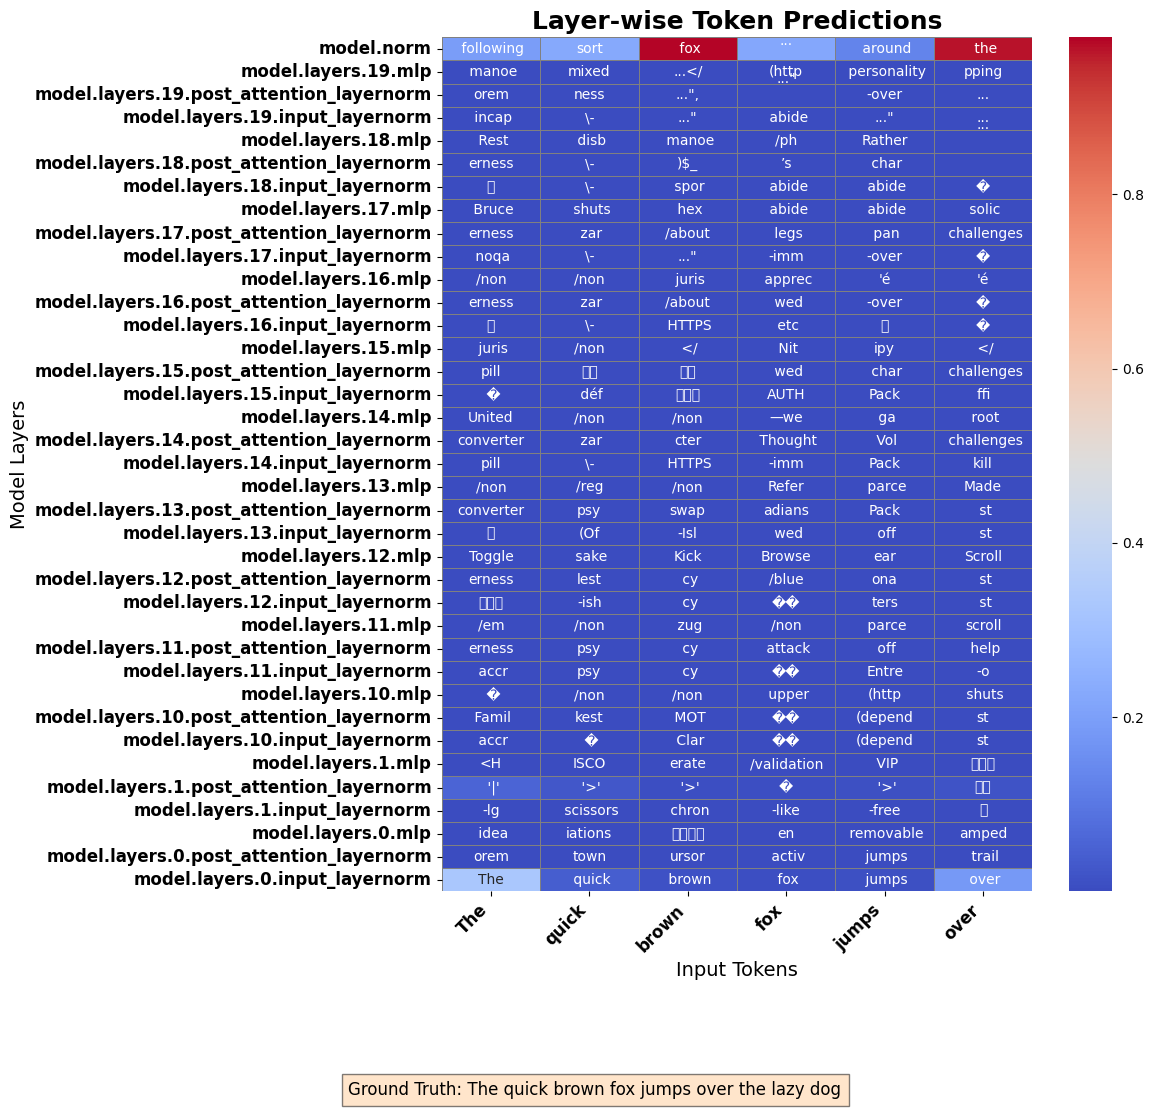

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Optional

def visualize_token_predictions_by_layer(
    input_text: str,
    analyzer,
    ground_truth: Optional[str] = None
):
    """
    Visualizes how different layers predict the next token for each input token.

    Args:
        input_text: The input text as a string
        analyzer: Initialized LLMLayerAnalyzer
        ground_truth: Optional expected continuation (if available)
    """
    tokens = input_text.split()
    fig, ax = plt.subplots(figsize=(max(12, len(tokens) * 2), 10))

    all_layer_predictions = []

    for i, token_end_idx in enumerate(range(1, len(tokens) + 1)):
        current_text = " ".join(tokens[:token_end_idx])
        analysis_results = analyzer.analyze_token_generation(current_text)
        all_layer_predictions.append(analysis_results)

    if all_layer_predictions:
        layer_names = sorted(
            all_layer_predictions[0]['layer_predictions'].keys(),
            key=lambda x: int(x.split('.')[-1]) if x.split('.')[-1].isdigit() else 999
        )[::-1]
    else:
        return fig, []

    heatmap_data = np.zeros((len(layer_names), len(tokens)))
    annotation_data = np.empty((len(layer_names), len(tokens)), dtype=object)

    for token_idx, analysis in enumerate(all_layer_predictions):
        for layer_idx, layer_name in enumerate(layer_names):
            layer_preds = analysis['layer_predictions'].get(layer_name, [])
            if layer_preds:
                heatmap_data[layer_idx, token_idx] = layer_preds[0]['probability']
                annotation_data[layer_idx, token_idx] = f"{layer_preds[0]['token']}"
            else:
                heatmap_data[layer_idx, token_idx] = 0.0
                annotation_data[layer_idx, token_idx] = "-"

    sns.heatmap(
        heatmap_data,
        cmap="coolwarm",
        annot=annotation_data,
        fmt="",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        ax=ax
    )

    ax.set_xticks(np.arange(len(tokens)) + 0.5)
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticks(np.arange(len(layer_names)) + 0.5)
    ax.set_yticklabels(layer_names, rotation=0, fontsize=12, fontweight='bold')

    plt.title(f"Layer-wise Token Predictions", fontsize=18, fontweight='bold')
    plt.xlabel("Input Tokens", fontsize=14)
    plt.ylabel("Model Layers", fontsize=14)

    if ground_truth:
        plt.figtext(
            0.5, -0.1,
            f"Ground Truth: {ground_truth}",
            ha="center",
            fontsize=12,
            bbox={"facecolor": "#ffcc99", "alpha": 0.5, "pad": 5}
        )

    plt.tight_layout()
    return fig, all_layer_predictions


if __name__ == "__main__":
    # Initialize analyzer
    analyzer = LLMLayerAnalyzer()

    # Example visualization
    fig, results = visualize_token_predictions_by_layer(
        "The quick brown fox jumps over ",
        analyzer,
        "The quick brown fox jumps over the lazy dog"
    )
    plt.show()

    # Clean up
    analyzer.cleanup()